<img width="10%" alt="Naas" src="https://landen.imgix.net/jtci2pxwjczr/assets/5ice39g4.png?w=160"/>


# LinkedIn - Follow content views monthly
<a href="https://app.naas.ai/user-redirect/naas/downloader?url=https://raw.githubusercontent.com/jupyter-naas/awesome-notebooks/master/LinkedIn/LinkedIn_Follow_content_views_monthly.ipynb" target="_parent"><img src="https://naasai-public.s3.eu-west-3.amazonaws.com/open_in_naas.svg"/></a><br><br><a href="https://github.com/jupyter-naas/awesome-notebooks/issues/new?assignees=&labels=&template=template-request.md&title=Tool+-+Action+of+the+notebook+">Template request</a> | <a href="https://github.com/jupyter-naas/awesome-notebooks/issues/new?assignees=&labels=bug&template=bug_report.md&title=LinkedIn+-+Follow+content+views+monthly:+Error+short+description">Bug report</a> | <a href="https://app.naas.ai/user-redirect/naas/downloader?url=https://raw.githubusercontent.com/jupyter-naas/awesome-notebooks/master/Naas/Naas_Start_data_product.ipynb" target="_parent">Generate Data Product</a>

**Tags:** #linkedin #html #plotly #csv #image #content #analytics #dependency

**Author:** [Florent Ravenel](https://www.linkedin.com/in/florent-ravenel/)

**Description:** This notebook provides a monthly overview of the content you are following on LinkedIn.

## Input

### Import libraries

In [26]:
import plotly.graph_objects as go
from naas_drivers import gsheet
import pandas as pd
import os
from datetime import date, datetime
import naas_data_product

### Setup variables
- `linkedin_url`: This variable stores the LinkedIn company URL that will be used as an input for the script.
- `output_dir`: This variable is used for storing the path to the directory where the output files will be saved.
- `subdir`: This variable is used for storing the name of a subdirectory where the output files will be saved.
- `force_update`: Force data update
- `scenario`: Type of analysis
- `title`: Graph title
- `col_date`: Date col to be used as x axis
- `col_value`: Value col to be aggregated on dataframe
- `agg_value`: Type of aggregation to perform on value col

In [27]:
# Inputs
spreadsheet_url = "https://docs.google.com/spreadsheets/d/1GDVJxBajYx7VR48yKGnSvMsEjzXvqI94hlmPXI5qEp8/edit#gid=0" or naas.secret.get("MY_AI_AVATAR_SPREADSHEET")
sheet_name = "CONTENT"

# Outputs
title = "Likes"  # Chart title
col_date = "PUBLISHED_DATE"
col_value = "LIKES"  # Column to sum
agg_value = "sum"

## Model

### Get data from Google Sheets spreadsheet

In [28]:
df_posts = gsheet.connect(spreadsheet_url).get(sheet_name=sheet_name)
print("Rows:", len(df_posts))
df_posts.head(1)

Rows: 40


,ENTITY,SCENARIO,SOURCE,PUBLISHED_DATE,DATE,TIME,TITLE,CONTENT,CONTENT_LENGTH,KEYWORDS,VIEWS,LIKES,COMMENTS,SHARES,ENGAGEMENT_SCORE,CONTENT_URL
0,Jérémy Ravenel,45253,LinkedIn,2023-11-22 16:31:57+0100,45252,0.688854,None,None,0,[],0,17,18,1,0.0,https://www.linkedin.com/feed/update/urn:li:ac...


### Create trend dataframe

In [31]:
DATE_FORMAT = "%Y-%m-%d"
PERIOD = "%Y-%m-%d"
PERIOD_TEXT = "Today"

def get_trend(
    df_init,
#     source,
#     entity,
#     scenario,
    label,
    col_date,
    col_value,
    agg_value,
    month_rolling=15
):
    # Init variable
    df = df_init.copy()

    # Groupby period
    if agg_value == "sum":
        df[col_value] = df[col_value].astype(float)
    df[col_date] = pd.to_datetime(df[col_date].str[:-6]).dt.strftime(DATE_FORMAT)
    df = df.groupby(col_date, as_index=False).agg({col_value: agg_value})

    # Rename column
    to_rename = {col_date: "DATE", col_value: "VALUE"}
    df = df.rename(columns=to_rename)

    # Reindex value
    d = datetime.now().date()
    d2 = df.loc[df.index[0], "DATE"]
    idx = pd.date_range(d2, d, freq="D")
    df.set_index("DATE", drop=True, inplace=True)
    df.index = pd.DatetimeIndex(df.index)
    df = df.reindex(idx, fill_value=0)
    df["DATE"] = pd.DatetimeIndex(df.index)

    # Groupby month
    df["DATE"] = pd.to_datetime(df["DATE"], format=DATE_FORMAT).dt.strftime(PERIOD)
    df = df.groupby("DATE", as_index=False).agg({"VALUE": "sum"})

    # Calc variation
    for index, row in df.iterrows():
        if index > 0:
            n = df.loc[df.index[index], "VALUE"]
            n_1 = df.loc[df.index[index - 1], "VALUE"]
            df.loc[df.index[index], "VALUE_COMP"] = n_1
            df.loc[df.index[index], "VARV"] = n - n_1
            if n_1 > 0:
                df.loc[df.index[index], "VARP"] = (n - n_1) / abs(n_1)
    df = df.fillna(0)

    # Plotly: Date display
    df["DATE_D"] = pd.to_datetime(df["DATE"], format=PERIOD).dt.strftime("%d %b")

    # Plotly: Value display
    df["VALUE_D"] = (
        "<b><span style='font-family: Arial;'>"
        + df["VALUE"].map("{:,.0f}".format).str.replace(",", " ")
        + "</span></b>"
    )

    # Plotly: Variation display
    df["VARV_D"] = df["VARV"].map("{:,.0f}".format).str.replace(",", " ")
    df.loc[df["VARV"] >= 0, "VARV_D"] = "+" + df["VARV_D"]
    df["VARP_D"] = df["VARP"].map("{:,.0%}".format).str.replace(",", " ")
    df.loc[df["VARP"] >= 0, "VARP_D"] = "+" + df["VARP_D"]

    # Plotly: hovertext
    df["TEXT"] = (
        "<b><span style='font-size: 14px;'>"
        + df["DATE_D"].astype(str)
        + ": "
        + df["VALUE_D"]
        + "</span></b><br>"
        "<span style='font-size: 12px;'>"
        + f"{PERIOD_TEXT}: "
        + df["VARV_D"]
        + " ("
        + df["VARP_D"]
        + ")</span>"
    )
    
#     # Add graph title
#     df.insert(loc=0, column="SOURCE", value=source)
#     df.insert(loc=1, column="ENTITY", value=entity)
#     df.insert(loc=2, column="SCENARIO", value=scenario)
#     df.insert(loc=3, column="LABEL", value=title)
    # Return month rolling
    return df[-month_rolling:].reset_index(drop=True)


df_trend = get_trend(
    df_posts,
#     source=source_dir_path,
#     entity=get_linkedin_id(linkedin_url),
#     scenario=scenario,
    label=title,
    col_date=col_date,
    col_value=col_value,
    agg_value=agg_value
)
df_trend

,DATE,VALUE,VALUE_COMP,VARV,VARP,DATE_D,VALUE_D,VARV_D,VARP_D,TEXT
0,2023-11-14,35.0,0.0,0.0,0.000000,14 Nov,<b><span style='font-family: Arial;'>35</span>...,+0,+0%,<b><span style='font-size: 14px;'>14 Nov: <b><...
1,2023-11-15,17.0,35.0,-18.0,-0.514286,15 Nov,<b><span style='font-family: Arial;'>17</span>...,-18,-51%,<b><span style='font-size: 14px;'>15 Nov: <b><...
2,2023-11-16,0.0,17.0,-17.0,-1.000000,16 Nov,<b><span style='font-family: Arial;'>0</span></b>,-17,-100%,<b><span style='font-size: 14px;'>16 Nov: <b><...
3,2023-11-17,20.0,0.0,20.0,0.000000,17 Nov,<b><span style='font-family: Arial;'>20</span>...,+20,+0%,<b><span style='font-size: 14px;'>17 Nov: <b><...
4,2023-11-18,33.0,20.0,13.0,0.650000,18 Nov,<b><span style='font-family: Arial;'>33</span>...,+13,+65%,<b><span style='font-size: 14px;'>18 Nov: <b><...
5,2023-11-19,51.0,33.0,18.0,0.545455,19 Nov,<b><span style='font-family: Arial;'>51</span>...,+18,+55%,<b><span style='font-size: 14px;'>19 Nov: <b><...
6,2023-11-20,32.0,51.0,-19.0,-0.372549,20 Nov,<b><span style='font-family: Arial;'>32</span>...,-19,-37%,<b><span style='font-size: 14px;'>20 Nov: <b><...
7,2023-11-21,13.0,32.0,-19.0,-0.593750,21 Nov,<b><span style='font-family: Arial;'>13</span>...,-19,-59%,<b><span style='font-size: 14px;'>21 Nov: <b><...
8,2023-11-22,54.0,13.0,41.0,3.153846,22 Nov,<b><span style='font-family: Arial;'>54</span>...,+41,+315%,<b><span style='font-size: 14px;'>22 Nov: <b><...
9,2023-11-23,0.0,54.0,-54.0,-1.000000,23 Nov,<b><span style='font-family: Arial;'>0</span></b>,-54,-100%,<b><span style='font-size: 14px;'>23 Nov: <b><...


## Output

### Display linechart

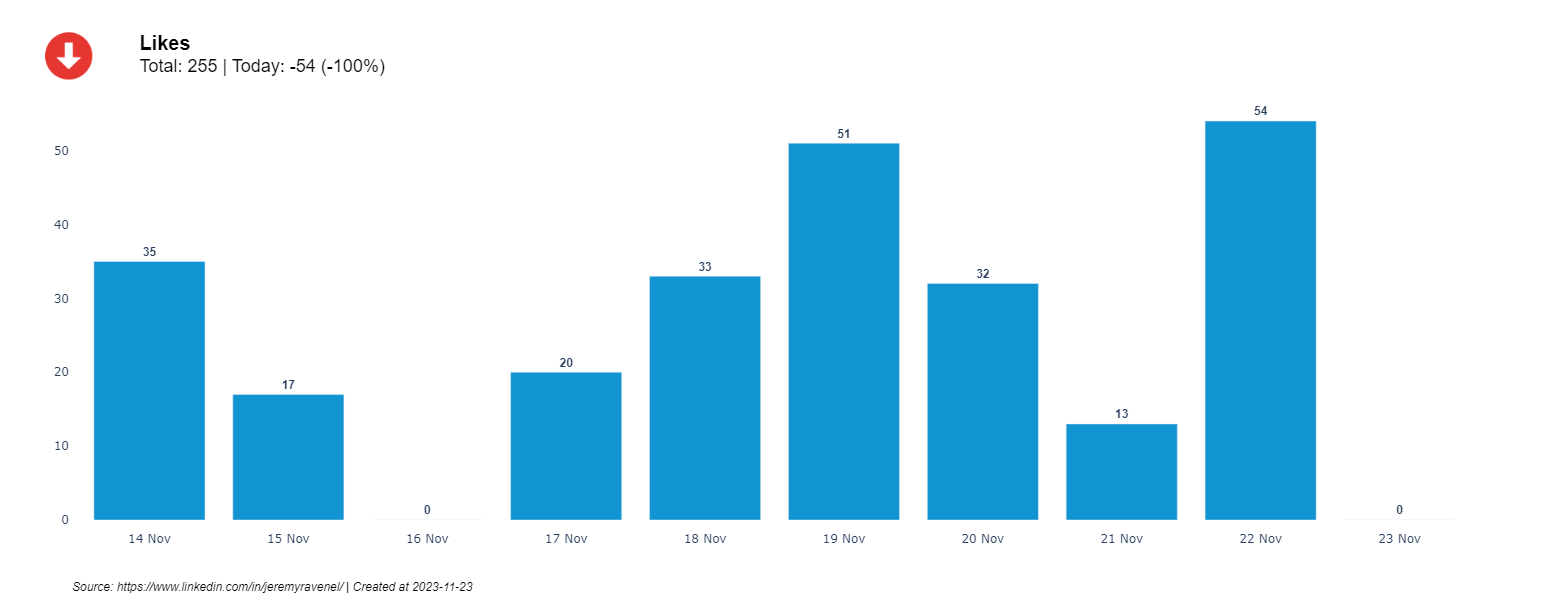

In [33]:
LINKEDIN_LOGO = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/ca/LinkedIn_logo_initials.png/800px-LinkedIn_logo_initials.png"  # Chart logo
LINKEDIN_COLOR = "#1293d2"  # Chart primary color
arrow_up = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Eo_circle_green_arrow-up.svg/2048px-Eo_circle_green_arrow-up.svg.png"
arrow_down = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b7/Eo_circle_red_arrow-down.svg/2048px-Eo_circle_red_arrow-down.svg.png"
arrow_right = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/42/Eo_circle_orange_arrow-right.svg/2048px-Eo_circle_orange_arrow-right.svg.png"

def create_barchart(
    df,
    title=None,
    linkedin_url=None,
    label="DATE_D",
    value="VALUE",
    value_d="VALUE_D",
    text="TEXT"
):
    # Init
    fig = go.Figure()
    
    # Plotly: Create title
    total_value = "{:,.0f}".format(df[value].sum()).replace(",", " ")
    varv = df.loc[df.index[-1], "VARV"]
    varp = df.loc[df.index[-1], "VARP"]
    varv_d = "{:,.0f}".format(varv).replace(",", " ")
    varp_d = "{:,.0%}".format(varp).replace(",", " ")
    if varv >= 0:
        varv_d = f"+{varv_d}"
        varp_d = f"+{varp_d}"
    title = f"<b><span style='font-size: 20px;'>{title}</span></b><br><span style='font-size: 18px;'>Total: {total_value} | {PERIOD_TEXT}: {varv_d} ({varp_d})</span>"
    
    # Logo
    logo = None
    if varv > 0:
        logo = arrow_up
    elif varv == 0:
        logo = arrow_right
    else:
        logo = arrow_down

    # Create fig
    fig.add_trace(
        go.Bar(
            x=df[label],
            y=df[value],
            text=df[value_d],
            textposition="outside",
            hoverinfo="text",
            hovertext=df[text],
            marker=dict(color=LINKEDIN_COLOR),
        )
    )
    # Add logo
    fig.add_layout_image(
        dict(
            source=logo,
            xref="paper",
            yref="paper",
            x=0.01,
            y=1.045,
            sizex=0.12,
            sizey=0.12,
            xanchor="right",
            yanchor="bottom",
        )
    )
    # Add annotation
    fig.add_annotation(
        text=f"<i>Source: <a href='{linkedin_url}'>{linkedin_url}</a> | Created at 2023-11-23",
        font=dict(family="Arial", color="black"),
        x=0,
        y=-0.25,
        xref="paper",
        yref="paper",
        xanchor="left",
        yanchor="bottom",
        arrowcolor="white",
    )
    fig.update_traces(showlegend=False)
    
    # Update layout
    fig.update_layout(
        title=title,
        title_x=0.09,
        title_font=dict(family="Arial", color="black"),
        paper_bgcolor="#ffffff",
        plot_bgcolor="#ffffff",
        width=1200,
        height=600,
        margin_pad=10,
        margin_b=80
    )
    fig.show()
    return fig

linkedin_url = "https://www.linkedin.com/in/jeremyravenel/"  # EXAMPLE "https://www.linkedin.com/in/XXXXXX/"
fig = create_barchart(df_trend, title, linkedin_url)

### Save and share your csv file

In [ ]:
# Save your dataframe in CSV
df_trend.to_csv(csv_output, index=False)

# Share output with naas
# naas.asset.add(csv_output)

# -> Uncomment the line below to remove your asset
# naas.asset.delete(csv_output)

### Save and share your graph in HTML


In [ ]:
# Save your graph in HTML
fig.write_html(html_output)

# Share output with naas
html_link = naas.asset.add(html_output, params={"inline": True})

# -> Uncomment the line below to remove your asset
# naas.asset.delete(html_output)

### Save and share your graph in image


In [ ]:
# Save your graph in PNG
fig.write_image(image_output)

# Share output with naas
image_link = naas.asset.add(image_output)

# -> Uncomment the line below to remove your asset
# naas.asset.delete(image_output)

### Create json

In [ ]:
# Read json
data = {}
data[title] = {}

# Add data to json
data[title]["data"] = df_trend.to_dict(orient="records")
data[title]["png"] = image_link
data[title]["html"] = html_link

# Save json
with open(json_output, "w") as f:
    json.dump(data, f)